<a href="https://colab.research.google.com/github/costayca/GroceryCNN/blob/main/GroceryCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import required libraries
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
#import model

## Resnet
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## NasNetLarge
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions

In [ ]:
%cd /content/drive/MyDrive/Licenta/23.11.2020/

/content/drive/MyDrive/Licenta/23.11.2020


In [ ]:
#image data generator

train_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory("dataset/train",
                                                    target_size=(331,331),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical")

Found 2455 images belonging to 37 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=preprocess_input)

valid_generator = valid_datagen.flow_from_directory("dataset/val",
                                                    target_size=(331,331),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical")

Found 296 images belonging to 37 classes.


## Transfer Learning

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
base_model = NASNetLarge(include_top=False, input_shape=(331,331,3))

343613440/343610240 [==============================] - 6s 0us/step


In [ ]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [ ]:
model_tl = Sequential()

model_tl.add(base_model)
model_tl.add(Flatten())
model_tl.add(Dense(37, activation="softmax"))

In [ ]:
model_tl.layers[0].trainable = False

In [ ]:
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
flatten_1 (Flatten)          (None, 487872)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                18051301  
Total params: 102,968,119
Trainable params: 18,051,301
Non-trainable params: 84,916,818
_________________________________________________________________


In [ ]:
# compiling
model_tl.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Create a checkpoint
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = "/content/drive/MyDrive/Licenta/23.11.2020/checkpoints/try1.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                            monitor="accuracy", 
                                            save_best_only=True, 
                                            verbose=1,
                                            mode='auto',
                                            save_freq='epoch')

In [32]:
fit_history = model_tl.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[model_checkpoint_callback])

Epoch 1/5
154/154 [==============================] - ETA: 0s - loss: 10.3486 - accuracy: 0.1923 
Epoch 00001: accuracy improved from -inf to 0.19226, saving model to /try1.hdf5
154/154 [==============================] - 2997s 19s/step - loss: 10.3486 - accuracy: 0.1923 - val_loss: 14.6894 - val_accuracy: 0.0946
Epoch 2/5
154/154 [==============================] - ETA: 0s - loss: 8.3568 - accuracy: 0.2717 
Epoch 00002: accuracy improved from 0.19226 to 0.27169, saving model to /try1.hdf5
154/154 [==============================] - 2967s 19s/step - loss: 8.3568 - accuracy: 0.2717 - val_loss: 15.7847 - val_accuracy: 0.1453
Epoch 3/5
154/154 [==============================] - ETA: 0s - loss: 7.6236 - accuracy: 0.3499 
Epoch 00003: accuracy improved from 0.27169 to 0.34990, saving model to /try1.hdf5
154/154 [==============================] - 2981s 19s/step - loss: 7.6236 - accuracy: 0.3499 - val_loss: 17.0856 - val_accuracy: 0.0980
Epoch 4/5
154/154 [==============================] - ETA: 0

In [33]:
model_tl.load_weights(checkpoint_filepath)

## Test the model

In [34]:
test_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory("dataset/test",
                                                    target_size=(331,331),
                                                    color_mode="rgb",
                                                    batch_size=1,
                                                    class_mode="categorical",
                                                    shuffle=False)

Found 2315 images belonging to 37 classes.


### Visualize predictions

In [35]:
test_generator.reset()

pred = model_tl.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
2315/2315 [==============================] - 2853s 1s/step


In [36]:
predicted_class_indices = np.argmax(pred, axis = 1)

In [37]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

In [38]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(331, 331)))

def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img, interpolation='nearest')

In [39]:
labelList = os.listdir("dataset/test")
labels = [labelList[predicted_class_indices[i]] for i in range(len(predicted_class_indices))]

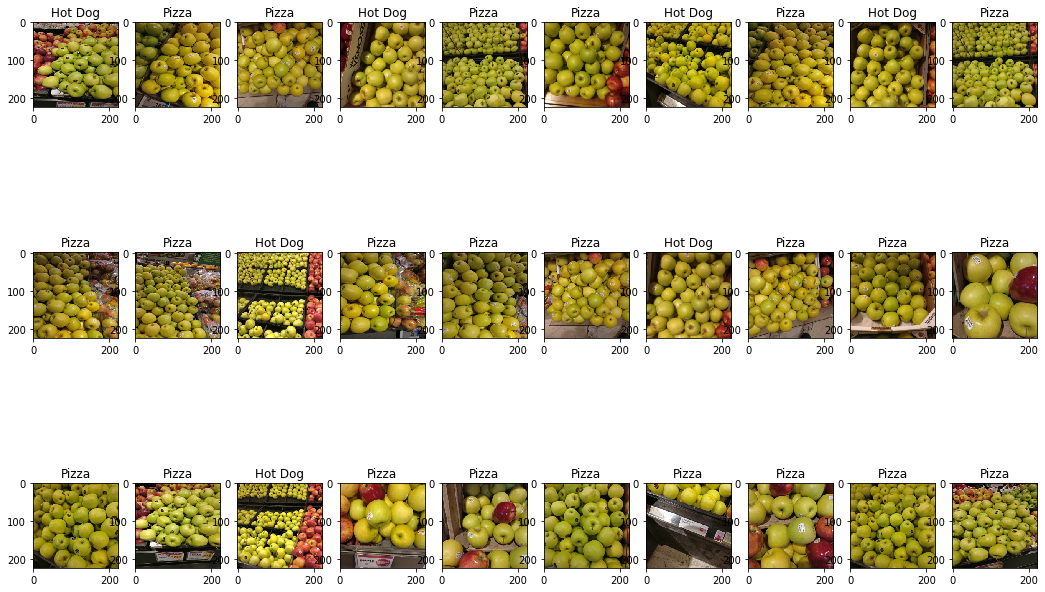

In [ ]:
plot_image("dataset/test", test_generator.filenames, 37, labels)